# Run it

In [ ]:
pip install mne

     |████████████████████████████████| 7.7 MB 26.4 MB/s 
  Created wheel for mne: filename=mne-1.0.1-py3-none-any.whl size=7542700 sha256=84fb20c1b60779d2650fb9be3241cc5a3fe63dedeb06a4e58bdae089cd143823
  Stored in directory: /root/.cache/pip/wheels/b1/16/e2/46ea7fb2215890e506fa85526ccbc2145663ad12c356d04c35
Successfully built mne


In [ ]:
import os
import numpy as np
import mne

from sklearn.preprocessing import MinMaxScaler, StandardScaler

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Visual
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, corrmap)
from scipy.stats import ttest_rel
from tensorflow.keras import utils as np_utils
from sklearn.utils import shuffle
import seaborn as sns

#CNN
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import keras
from keras import layers

In [ ]:
dataPath = '/content/drive/MyDrive/databbci/data'

In [ ]:
import os

active = []
passive = []
cue = []


data_number = 0
for dir in os.listdir(dataPath):
  for filename in os.listdir(os.path.join(dataPath, dir)):
    #if filename.endswith(".vhdr"):
    tmp = os.path.join(os.path.join(dataPath, dir), filename)
      #with open(os.path.join(os.path.join(dataPath, dir), filename), 'r') as f: # open in readonly mode
    if filename.endswith("active.vhdr"):
      active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("passive.vhdr"):
      passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("_cue.vhdr"):
      cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
print(len(cue))

<ipython-input-4-49b4c4c928fa>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-49b4c4c928fa>:15: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-49b4c4c928fa>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-49b4c4c928fa>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-49b4c4c928fa>:15: RuntimeWarning: Online software filter detected. Using software filter set

3


# Function | Run All

    func: raw_to_data(raw, non_active = 0) 
    * active = 0
    * passive = 1
    * cue = 2
    return X, y

\-

    def get_train_test(act, pas, cue): 
    * active[subject] -> act
    * call function "raw_to_data"
    return train_X, test_X, train_y, test_y

\- LDA

  
    def lda_101(train_X, test_X, train_y, test_y):
    return clf, cm

\- CNN

    def cnn_101(train_X, test_X, train_y, test_y):
    * batch_size = 16
    * epochs = 100
    * num_classes = 2
    return cnn_model, cnn_train, test_eval, cm_cnn


\- Visualization

    def vis_confusion_matrix(cm):
    * plot 


## All data load

In [ ]:
def raw_to_data(raw, non_active = 0):
  raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
  raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
  #raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

  events, _ = mne.events_from_annotations(raw, verbose=False)
  tmin, tmax = -0., 1.  # in s
  baseline = (0, 0)

  #passive -> ignore 
  #cue -> active
  # -> active, ignore
  event_dict = {'active': 1, 'ignore': 2}
  if non_active != 0:
    event_dict.clear()
    if non_active == 1: #passive
      event_dict = {'ignore': 2}
    else: # cue
      event_dict = {'active': 1}
  
  epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=baseline, preload = True, verbose=False)
  # print(epochs.events.size)
  # print(epochs.event_id)
  # {'active': 1, 'ignore': 2}

  #preprocessing
  filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
  ica = ICA(n_components=10, max_iter='auto', random_state=97)
  ica.fit(epochs)

  X = epochs.get_data()*1000  # MEG signals: n_epochs, n_meg_channels, n_times
  y = epochs.events[:, 2]  # target: auditory left vs visual left
  #print(X.shape, y.shape)

  return X, y

## Preprocessing

In [ ]:
def get_train_test(act, pas, cue):
  # subject = 0
  train_X, train_y = raw_to_data(act, 0)
  pas_X, pas_y = raw_to_data(pas, 1) #passive = 1
  cue_X, cue_y = raw_to_data(cue, 2) #ignore = 2

  test_X = np.append(cue_X, pas_X, axis = 0)
  test_y = np.append(cue_y, pas_y, axis = 0)
  test_X, test_y = shuffle(test_X, test_y, random_state=10)

  train_X = train_X[:,:,:100]
  test_X = test_X[:,:,:100]

  all_data = np.append(train_X, test_X, axis = 0)
  all_data_labels = np.append(train_y, test_y, axis = 0)

  train_X, test_X, train_y, test_y = train_test_split(all_data, all_data_labels, test_size=0.2, random_state=42)

  return train_X, test_X, train_y, test_y


In [ ]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [ ]:
def encoder(X_train, X_test, y_train, y_test):
  # number of input columns
  # n_inputs = X_train.shape[1]
  # split into train test sets
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
  # scale data
  # t = MinMaxScaler()
  # t.fit(X_train)
  # X_train = t.transform(X_train)
  # X_test = t.transform(X_test)
  # define encoder
  # visible = Input(shape=(n_inputs, 101))
  # encoder level 1

  input = keras.Input(shape=(10, 100, 1))

  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  # x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (3, 1), activation='sigmoid')(x)
  autoencoder = keras.Model(input, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  # # output layer
  # output = Dense(n_inputs, activation='linear')(d)
  # # define autoencoder model
  # model = Model(inputs=visible, outputs=output)
  # # compile autoencoder model
  # model.compile(optimizer='adam', loss='mse')
  # # plot the autoencoder
  plot_model(autoencoder, 'autoencoder_compress.png', show_shapes=True)
  return autoencoder

## LDA Function

In [ ]:
def lda_101(train_X, test_X, train_y, test_y):
  n = train_X.shape[0]
  train_lda = train_X.reshape(n,-1)
  n = test_X.shape[0]
  test_lda = test_X.reshape(n, -1)

  clf = LDA()
  clf.fit(train_lda, train_y)

  y_pred = clf.predict(test_lda)
  cm = confusion_matrix(test_y, y_pred)
  print(cm)
  print('Accuracy' + str(accuracy_score(test_y, y_pred)))

  return clf, cm

## CNN Functions

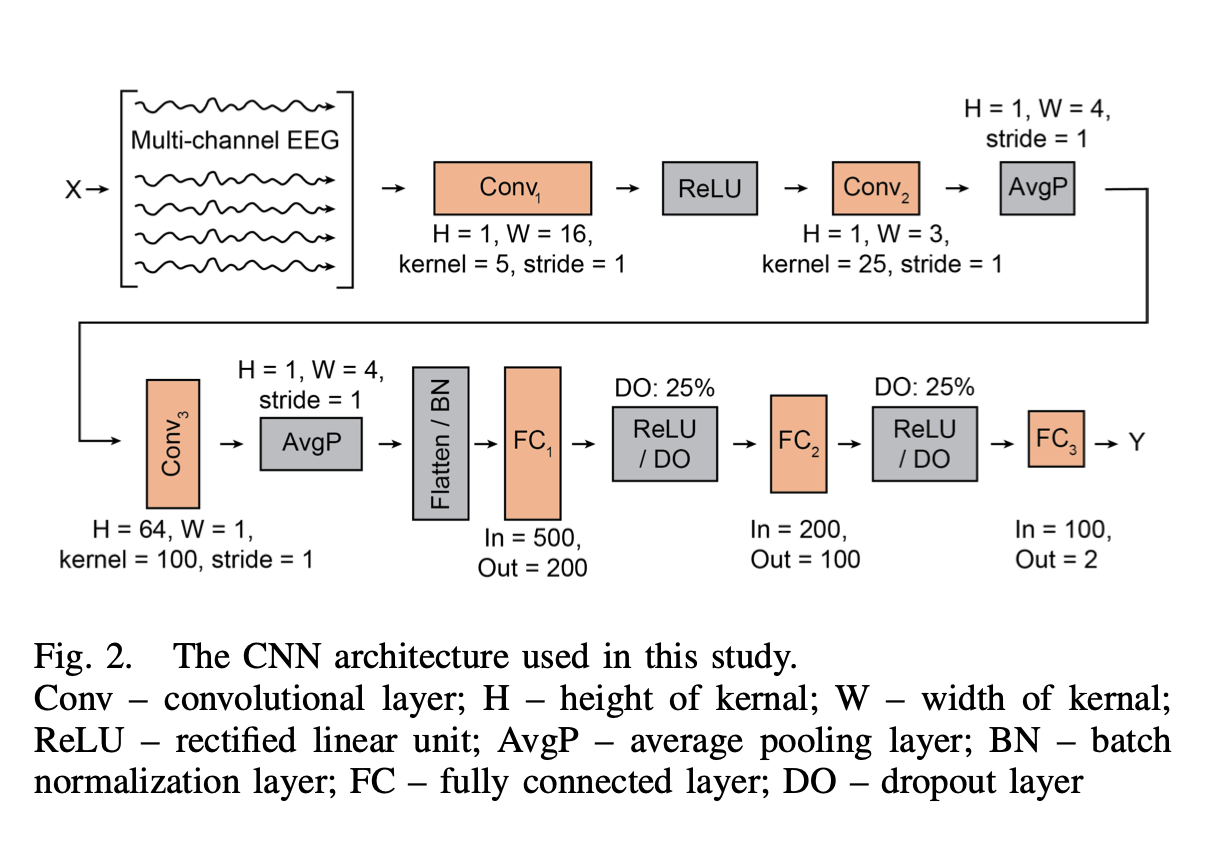

In [ ]:
def cnn_ieee(train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100):
  train_X = train_X.reshape(-1, 10,100, 1)
  test_X = test_X.reshape(-1, 10,100, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.3, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)
  # batch_size = 32
  # epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(5, kernel_size=(1, 16),activation='relu', input_shape=(10,100,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  # cnn_model.add(BatchNormalization())
  # cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(25, (1, 3), activation='relu',padding='same'))
  cnn_model.add(AveragePooling2D(pool_size=(1, 4)))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  # cnn_model.add(BatchNormalization())
  # cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(100, (1, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  # cnn_model.add(BatchNormalization())
  # cnn_model.add(Dropout(0.25))

  cnn_model.add(Flatten())
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dense(200, activation='relu'))
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Dense(100, activation='relu'))
  cnn_model.add(Dropout(0.25))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  # opt = SGD(lr=0.0001)
  opt = Adam(lr=0.0001, decay=0.01)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return cnn_model, cnn_train, test_eval, cm_cnn


In [ ]:
def cnn_101(train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100):
  train_X = train_X.reshape(-1, 10,101, 1)
  test_X = test_X.reshape(-1, 10,101, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)
  # batch_size = 32
  # epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(8, kernel_size=(40, 4),activation='relu',input_shape=(10,101,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(16, (80, 4), activation='relu',padding='same'))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(32, (80, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  opt = SGD(lr=0.01)
  #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return cnn_model, cnn_train, test_eval, cm_cnn


In [ ]:
def vis_acc_loss(cnn_train):
  accuracy = cnn_train.history['accuracy']
  val_accuracy = cnn_train.history['val_accuracy']
  loss = cnn_train.history['loss']
  val_loss = cnn_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

## Visualization Functions

In [ ]:
def vis_confusion_matrix(cm):


  ax = sns.heatmap(cm, annot=True, 
            fmt='', cmap='Blues')
  
  # group_counts = ["{0:0.0f}".format(value) for value in
  #                 confusion_matrix.flatten()]

  # labels = [f"{v1}\n" for v1 in zip(group_counts)]

  # labels = np.asarray(labels).reshape(2,2)
  
  ax.set_title('CNN Confusion Matrix \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['NI','AC'])
  ax.yaxis.set_ticklabels(['NI','AC'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()


# Test | All Subjects

In [ ]:
cnn_models = []
lda_models = []

## Test: LDA & CNN | Subject 1

In [ ]:
subject = 0

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 1.7s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.4s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.2s.


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


LDA

[[45 43]
 [31 45]]
Accuracy0.5487804878048781


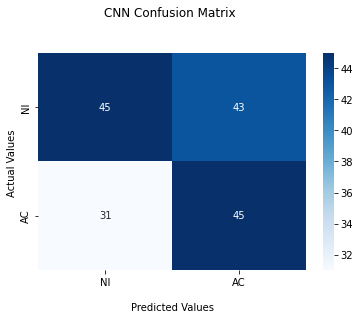

In [ ]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

CNN

In [ ]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y,
                                                  batch_size = 64,
                                                  epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5882
Epoch 1: val_loss improved from inf to 0.69090, saving model to /tmp/checkpoint.h5
8/8 [==============================] - 2s 205ms/step - loss: 0.6767 - accuracy: 0.5882 - val_loss: 0.6909 - val_accuracy: 0.6548
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.7386
Epoch 2: val_loss improved from 0.69090 to 0.68648, saving model to /tmp/checkpoint.h5
8/8 [==============================] - 1s 172ms/step - loss: 0.6335 - accuracy: 0.7386 - val_loss: 0.6865 - val_accuracy: 0.6447
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.7603
Epoch 3: val_loss improved from 0.68648 to 0.67799, saving model to /tmp/checkpoint.h5
8/8 [==============================] - 1s 172ms/step - loss: 0.5900 - accuracy: 0.7603 - val_loss: 0.6780 - val_accuracy: 0.6497
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8

In [ ]:
cnn_model.save("cnn_model_1.h5py")

INFO:tensorflow:Assets written to: cnn_model_1.h5py/assets


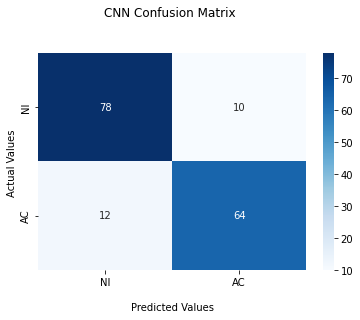

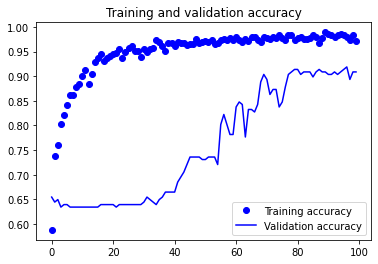

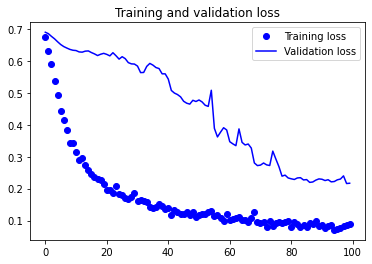

In [ ]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.32752278447151184
Test accuracy: 0.8658536672592163


With Autoencoder

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(train_X.shape[1]):
  scalers[i] = MinMaxScaler()
  # train_X[:, i, :] = sgolay2d(train_X[:, i, :], window_size=29, order=0)
  train_X[:, i, :] = scalers[i].fit_transform(train_X[:, i, :]) 

for i in range(test_X.shape[1]):
  # test_X[:, i, :] = sgolay2d(test_X[:, i, :], window_size=29, order=0)
  test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 

from keras.callbacks import TensorBoard

train_X = train_X.reshape(-1, 10,100, 1)
test_X = test_X.reshape(-1, 10,100, 1)


en = encoder(train_X, test_X, train_y, test_y)

en.fit(train_X, train_X,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test_X, test_X))
en.save('/content/drive/MyDrive/databbci/encoder.h5')

train_X_predict = en.predict(train_X).reshape(-1, 10, 100)
test_X_predict = en.predict(test_X).reshape(-1, 10, 100)
train_X_predict.shape, test_X_predict.shape

Epoch 1/50
11/11 [==============================] - 2s 97ms/step - loss: 0.6942 - val_loss: 0.6915
Epoch 2/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6908 - val_loss: 0.6894
Epoch 3/50
11/11 [==============================] - 1s 82ms/step - loss: 0.6880 - val_loss: 0.6847
Epoch 4/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6778 - val_loss: 0.6603
Epoch 5/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6499 - val_loss: 0.6437
Epoch 6/50
11/11 [==============================] - 1s 81ms/step - loss: 0.6437 - val_loss: 0.6427
Epoch 7/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6410 - val_loss: 0.6398
Epoch 8/50
11/11 [==============================] - 1s 82ms/step - loss: 0.6381 - val_loss: 0.6370
Epoch 9/50
11/11 [==============================] - 1s 82ms/step - loss: 0.6358 - val_loss: 0.6352
Epoch 10/50
11/11 [==============================] - 1s 81ms/step - loss: 0.6336 - val_loss: 0.6322
Epoch 11/

((656, 10, 100), (164, 10, 100))

[[56 32]
 [29 47]]
Accuracy0.6280487804878049


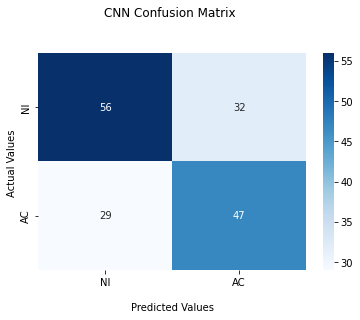

In [ ]:
clf_lda, cm_lda = lda_101(train_X_predict, test_X_predict, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model_tune, cnn_train_tune, test_eval_tune, cm_cnn_tune = cnn_ieee(train_X_predict, 
                                                                      test_X_predict, 
                                                                      train_y, 
                                                                      test_y,
                                                                      batch_size = 32,
                                                                      epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15/15 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.6231
Epoch 1: val_loss improved from inf to 0.69262, saving model to /tmp/checkpoint.h5
15/15 [==============================] - 4s 201ms/step - loss: 0.6711 - accuracy: 0.6231 - val_loss: 0.6926 - val_accuracy: 0.5076
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6667
Epoch 2: val_loss improved from 0.69262 to 0.68659, saving model to /tmp/checkpoint.h5
15/15 [==============================] - 2s 114ms/step - loss: 0.6213 - accuracy: 0.6667 - val_loss: 0.6866 - val_accuracy: 0.6447
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7211
Epoch 3: val_loss improved from 0.68659 to 0.68501, saving model to /tmp/checkpoint.h5
15/15 [==============================] - 2s 117ms/step - loss: 0.5843 - accuracy: 0.7211 - val_loss: 0.6850 - val_accuracy: 0.6497
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.5598 -

In [ ]:
print('Test loss:', test_eval_tune[0])
print('Test accuracy:', test_eval_tune[1])

Test loss: 0.5995848774909973
Test accuracy: 0.707317054271698


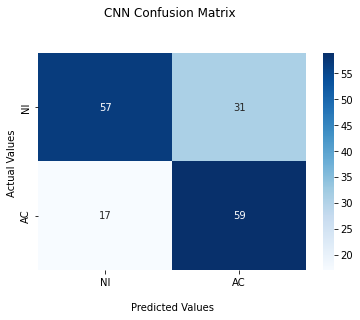

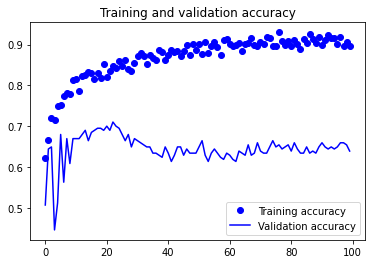

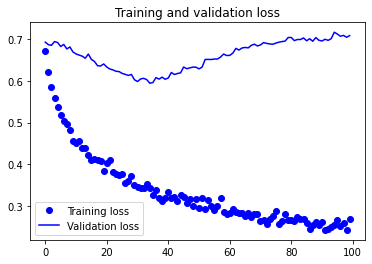

In [ ]:
vis_confusion_matrix(cm_cnn_tune)

vis_acc_loss(cnn_train_tune)

## LDA & CNN | Subject 2

In [ ]:
subject = 1

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 1.8s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.5s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.9s.


In [ ]:
from collections import Counter
print(Counter(train_y))
print(Counter(test_y))

Counter({1: 372, 2: 284})
Counter({1: 88, 2: 76})


No handles with labels found to put in legend.


1


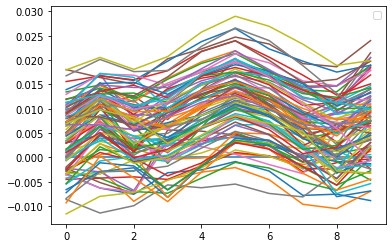

In [ ]:
n = 10
print(train_y[n])
plt.plot(train_X[n,:,:])
plt.legend()
plt.show()

[[48 40]
 [36 40]]
Accuracy0.5365853658536586


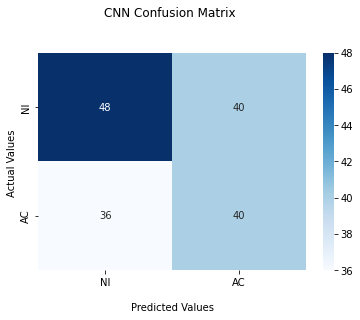

In [ ]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y,
                                                  28,
                                                  epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.5839
Epoch 1: val_loss improved from inf to 0.71531, saving model to /tmp/checkpoint.h5
17/17 [==============================] - 4s 168ms/step - loss: 0.7959 - accuracy: 0.5839 - val_loss: 0.7153 - val_accuracy: 0.3756
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.6231
Epoch 2: val_loss improved from 0.71531 to 0.71503, saving model to /tmp/checkpoint.h5
17/17 [==============================] - 2s 108ms/step - loss: 0.7037 - accuracy: 0.6231 - val_loss: 0.7150 - val_accuracy: 0.3655
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.6471
Epoch 3: val_loss improved from 0.71503 to 0.68394, saving model to /tmp/checkpoint.h5
17/17 [==============================] - 2s 113ms/step - loss: 0.6662 - accuracy: 0.6471 - val_loss: 0.6839 - val_accuracy: 0.6548
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 0.6240 -

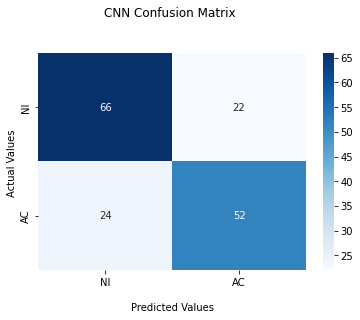

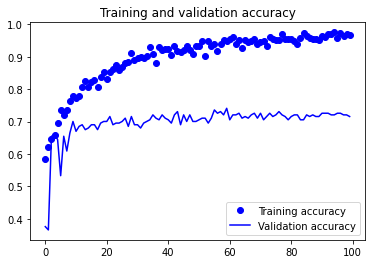

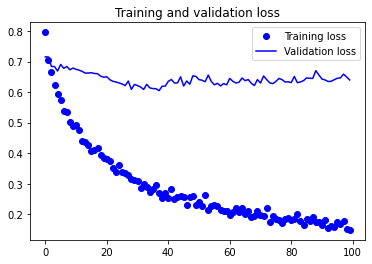

In [ ]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6839898228645325
Test accuracy: 0.7195122241973877


With Autoencoder

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(train_X.shape[1]):
  scalers[i] = MinMaxScaler()
  # train_X[:, i, :] = sgolay2d(train_X[:, i, :], window_size=29, order=0)
  train_X[:, i, :] = scalers[i].fit_transform(train_X[:, i, :]) 

for i in range(test_X.shape[1]):
  # test_X[:, i, :] = sgolay2d(test_X[:, i, :], window_size=29, order=0)
  test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 

In [ ]:
from keras.callbacks import TensorBoard

train_X = train_X.reshape(-1, 10,100, 1)
test_X = test_X.reshape(-1, 10,100, 1)


en = encoder(train_X, test_X, train_y, test_y)

en.fit(train_X, train_X,
                epochs=50,
                batch_size=len(train_X),
                shuffle=True,
                validation_data=(test_X, test_X))
# en.save('/content/drive/MyDrive/databbci/encoder.h5')

train_X_predict = en.predict(train_X).reshape(-1, 10, 100)
test_X_predict = en.predict(test_X).reshape(-1, 10, 100)
train_X_predict.shape, test_X_predict.shape

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6926 - val_loss: 0.6922
Epoch 2/50
1/1 [==============================] - 1s 775ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 3/50
1/1 [==============================] - 1s 786ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 4/50
1/1 [==============================] - 1s 783ms/step - loss: 0.6904 - val_loss: 0.6907
Epoch 5/50
1/1 [==============================] - 1s 806ms/step - loss: 0.6898 - val_loss: 0.6903
Epoch 6/50
1/1 [==============================] - 1s 766ms/step - loss: 0.6891 - val_loss: 0.6899
Epoch 7/50
1/1 [==============================] - 1s 773ms/step - loss: 0.6885 - val_loss: 0.6897
Epoch 8/50
1/1 [==============================] - 1s 772ms/step - loss: 0.6880 - val_loss: 0.6895
Epoch 9/50
1/1 [==============================] - 1s 780ms/step - loss: 0.6875 - val_loss: 0.6894
Epoch 10/50
1/1 [==============================] - 1s 766ms/step - loss: 0.6871 - val_loss: 0.6893
Epoch 11/50
1/1 [=====

((656, 10, 100), (164, 10, 100))

No handles with labels found to put in legend.


1


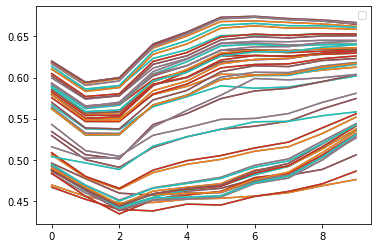

In [ ]:
n = 10
print(train_y[n])
plt.plot(train_X_predict[n,:,:])
plt.legend()
plt.show()

[[48 40]
 [42 34]]
Accuracy0.5


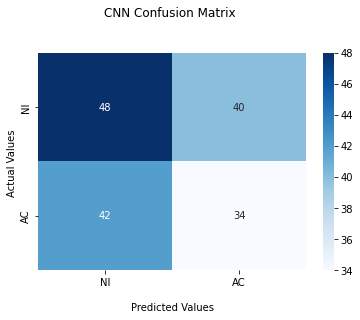

In [ ]:
clf_lda, cm_lda = lda_101(train_X_predict, test_X_predict, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model_tune, cnn_train_tune, test_eval_tune, cm_cnn_tune = cnn_ieee(train_X_predict, 
                                                                      test_X_predict, 
                                                                      train_y, 
                                                                      test_y,
                                                                      30,
                                                                      epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


16/16 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.5926
Epoch 1: val_loss improved from inf to 0.68893, saving model to /tmp/checkpoint.h5
16/16 [==============================] - 3s 131ms/step - loss: 0.7494 - accuracy: 0.5926 - val_loss: 0.6889 - val_accuracy: 0.6650
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.5664
Epoch 2: val_loss improved from 0.68893 to 0.68432, saving model to /tmp/checkpoint.h5
16/16 [==============================] - 2s 108ms/step - loss: 0.7226 - accuracy: 0.5664 - val_loss: 0.6843 - val_accuracy: 0.6599
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5817
Epoch 3: val_loss improved from 0.68432 to 0.66513, saving model to /tmp/checkpoint.h5
16/16 [==============================] - 2s 108ms/step - loss: 0.6969 - accuracy: 0.5817 - val_loss: 0.6651 - val_accuracy: 0.6345
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.6649 -

In [ ]:
cnn_model.save("'/content/drive/MyDrive/databbci/cnn_model_2.h5py")

INFO:tensorflow:Assets written to: cnn_model_2.h5py/assets


In [ ]:
tmp = test_X[1].reshape(10,100,1)
print(tmp.shape)
print(cnn_model.predict(test_X, batch_size=124))
print(test_y[0])

(10, 100, 1)
[[0.5403531  0.48561817]
 [0.5415746  0.4909963 ]
 [0.54061717 0.48333442]
 [0.51923364 0.46938333]
 [0.49795803 0.4612712 ]
 [0.50289845 0.4622757 ]
 [0.49072927 0.4576956 ]
 [0.4907297  0.46066827]
 [0.4796159  0.46966064]
 [0.46928328 0.48880368]
 [0.48206773 0.49015945]
 [0.4714606  0.47603628]
 [0.4992634  0.50201756]
 [0.4876756  0.49893892]
 [0.47816068 0.512499  ]
 [0.4670898  0.4734745 ]
 [0.46107566 0.4848306 ]
 [0.46641317 0.4629807 ]
 [0.4763867  0.4868711 ]
 [0.49037626 0.4872207 ]
 [0.49332973 0.48633417]
 [0.49477106 0.4879439 ]
 [0.47194052 0.48111084]
 [0.49485743 0.48671135]
 [0.47714233 0.48078015]
 [0.48231283 0.4811642 ]
 [0.465384   0.48133934]
 [0.45366398 0.47529218]
 [0.46342173 0.47402674]
 [0.4692192  0.4685071 ]
 [0.48368755 0.47206348]
 [0.4961835  0.4802755 ]
 [0.49994567 0.4803313 ]
 [0.49847975 0.48588938]
 [0.49607497 0.4817906 ]
 [0.49901068 0.48632705]
 [0.49504697 0.5025257 ]
 [0.5014696  0.48324454]
 [0.49272567 0.48644996]
 [0.4971585 

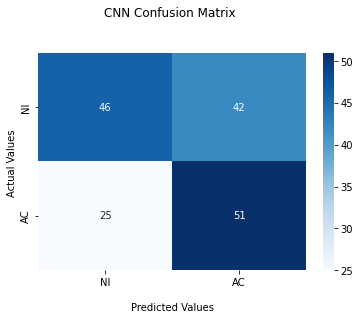

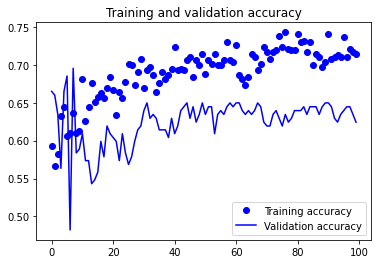

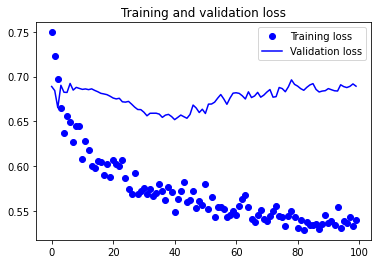

In [ ]:
vis_confusion_matrix(cm_cnn_tune)

vis_acc_loss(cnn_train_tune)

In [ ]:
print('Test loss:', test_eval_tune[0])
print('Test accuracy:', test_eval_tune[1])

Test loss: 0.658076286315918
Test accuracy: 0.5914633870124817


## Test 3: LDA & CNN | Subject 3

In [ ]:
subject = 2

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 1.1s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.6s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.3s.


[[53 40]
 [34 31]]
Accuracy0.5316455696202531


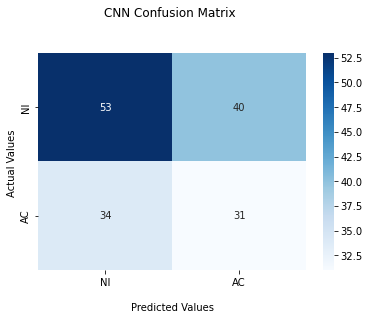

In [ ]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y, 124 , 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/5 [=======================>......] - ETA: 0s - loss: 0.5551 - accuracy: 0.6673
Epoch 1: val_loss improved from inf to 0.63215, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 2s 295ms/step - loss: 0.5537 - accuracy: 0.6693 - val_loss: 0.6321 - val_accuracy: 0.5906
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.7545
Epoch 2: val_loss improved from 0.63215 to 0.62342, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 1s 254ms/step - loss: 0.4590 - accuracy: 0.7545 - val_loss: 0.6234 - val_accuracy: 0.5906
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8198
Epoch 3: val_loss did not improve from 0.62342
5/5 [==============================] - 1s 218ms/step - loss: 0.4446 - accuracy: 0.8198 - val_loss: 0.6236 - val_accuracy: 0.5906
Epoch 4/100
4/5 [=======================>......] - ETA: 0s - loss: 0.4070 - accuracy: 0.8286
Epoch 4: val_loss improved from 0.62

In [ ]:
cnn_model.save("/content/drive/MyDrive/databbci/cnn_model_3_90.h5py")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/databbci/cnn_model_3_90.h5py/assets


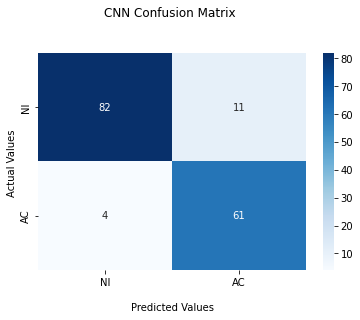

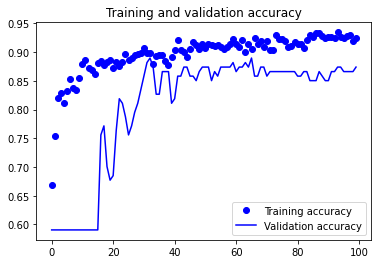

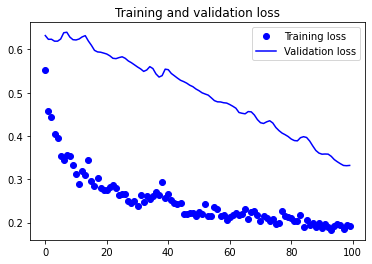

In [ ]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.30953121185302734
Test accuracy: 0.905063271522522


With autoencoder

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(train_X.shape[1]):
  scalers[i] = MinMaxScaler()
  # train_X[:, i, :] = sgolay2d(train_X[:, i, :], window_size=29, order=0)
  train_X[:, i, :] = scalers[i].fit_transform(train_X[:, i, :]) 

for i in range(test_X.shape[1]):
  # test_X[:, i, :] = sgolay2d(test_X[:, i, :], window_size=29, order=0)
  test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 

from keras.callbacks import TensorBoard

train_X = train_X.reshape(-1, 10,100, 1)
test_X = test_X.reshape(-1, 10,100, 1)


en = encoder(train_X, test_X, train_y, test_y)

en.fit(train_X, train_X,
                epochs=50,
                batch_size=len(train_X),
                shuffle=True,
                validation_data=(test_X, test_X))
en.save('/content/drive/MyDrive/databbci/encoder.h5')

train_X_predict = en.predict(train_X).reshape(-1, 10, 100)
test_X_predict = en.predict(test_X).reshape(-1, 10, 100)
train_X_predict.shape, test_X_predict.shape

Epoch 1/50
5/5 [==============================] - 2s 207ms/step - loss: 0.6871 - val_loss: 0.6801
Epoch 2/50
5/5 [==============================] - 1s 170ms/step - loss: 0.6746 - val_loss: 0.6725
Epoch 3/50
5/5 [==============================] - 1s 175ms/step - loss: 0.6724 - val_loss: 0.6725
Epoch 4/50
5/5 [==============================] - 1s 192ms/step - loss: 0.6700 - val_loss: 0.6713
Epoch 5/50
5/5 [==============================] - 1s 192ms/step - loss: 0.6701 - val_loss: 0.6704
Epoch 6/50
5/5 [==============================] - 1s 172ms/step - loss: 0.6686 - val_loss: 0.6696
Epoch 7/50
5/5 [==============================] - 1s 169ms/step - loss: 0.6677 - val_loss: 0.6682
Epoch 8/50
5/5 [==============================] - 1s 170ms/step - loss: 0.6665 - val_loss: 0.6671
Epoch 9/50
5/5 [==============================] - 1s 171ms/step - loss: 0.6652 - val_loss: 0.6657
Epoch 10/50
5/5 [==============================] - 1s 172ms/step - loss: 0.6635 - val_loss: 0.6637
Epoch 11/50
5/5 [==

((632, 10, 100), (158, 10, 100))

[[58 35]
 [17 48]]
Accuracy0.6708860759493671


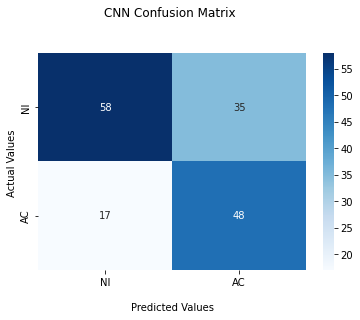

In [ ]:
clf_lda, cm_lda = lda_101(train_X_predict, test_X_predict, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

No handles with labels found to put in legend.


1


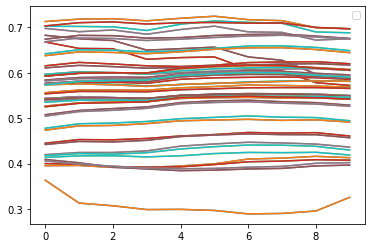

In [ ]:
n = 100
print(train_y[n])
plt.plot(train_X_predict[n,:,:])
plt.legend()
plt.show()

In [ ]:
cnn_model_tune, cnn_train_tune, test_eval_tune, cm_cnn_tune = cnn_ieee(train_X_predict, 
                                                                      test_X_predict, 
                                                                      train_y, 
                                                                      test_y, 124 , 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6059
Epoch 1: val_loss improved from inf to 0.68424, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 2s 344ms/step - loss: 0.6364 - accuracy: 0.6059 - val_loss: 0.6842 - val_accuracy: 0.5906
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7525
Epoch 2: val_loss improved from 0.68424 to 0.67352, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 1s 280ms/step - loss: 0.5004 - accuracy: 0.7525 - val_loss: 0.6735 - val_accuracy: 0.5906
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7941
Epoch 3: val_loss improved from 0.67352 to 0.66533, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 1s 271ms/step - loss: 0.4845 - accuracy: 0.7941 - val_loss: 0.6653 - val_accuracy: 0.5906
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7

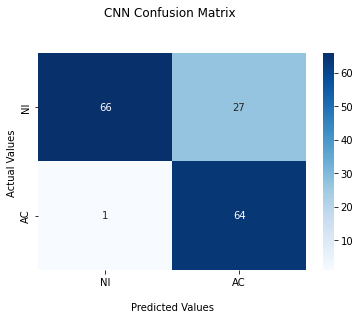

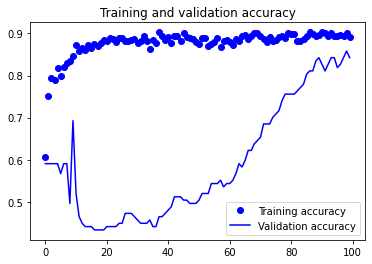

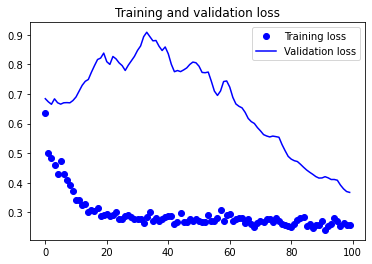

In [ ]:
vis_confusion_matrix(cm_cnn_tune)

vis_acc_loss(cnn_train_tune)

In [ ]:
print('Test loss:', test_eval_tune[0])
print('Test accuracy:', test_eval_tune[1])

Test loss: 0.37530481815338135
Test accuracy: 0.8227847814559937


# Tune Autoencoder

In [ ]:
tX, tsX, ty, tsy = train_X.copy(), test_X.copy(), train_y.copy(), test_y.copy()

tAc, _ = raw_to_data(active[0], 2) #active
tNi, _ = raw_to_data(active[0], 1) #ignore

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-11-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.8s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-11-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.4s.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(tX.shape[1]):
  scalers[i] = MinMaxScaler()
  tX[:, i, :] = sgolay2d(tX[:, i, :], window_size=29, order=0)
  tX[:, i, :] = scalers[i].fit_transform(tX[:, i, :]) 

for i in range(tsX.shape[1]):
  tsX[:, i, :] = sgolay2d(tsX[:, i, :], window_size=29, order=0)
  tsX[:, i, :] = scalers[i].transform(tsX[:, i, :]) 

for i in range(tAc.shape[1]):
  tAc[:, i, :] = sgolay2d(tAc[:, i, :], window_size=29, order=0)
  tAc[:, i, :] = scalers[i].fit_transform(tAc[:, i, :]) 

for i in range(tNi.shape[1]):
  tNi[:, i, :] = sgolay2d(tNi[:, i, :], window_size=29, order=0)
  tNi[:, i, :] = scalers[i].fit_transform(tNi[:, i, :]) 

ValueError: ignored

In [ ]:
tAc

array([[[0.38500907, 0.36771269, 0.35146475, ..., 0.        ,
         0.        , 0.        ],
        [0.19350592, 0.18540414, 0.17376624, ..., 0.        ,
         0.        , 0.        ],
        [0.33220116, 0.31466149, 0.29318059, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.33538244, 0.30059472, 0.24913733, ..., 0.        ,
         0.        , 0.        ],
        [0.19144186, 0.17034593, 0.13488856, ..., 0.        ,
         0.        , 0.        ],
        [0.42325775, 0.39814275, 0.36250615, ..., 0.14582529,
         0.14050965, 0.14165154]],

       [[0.42148493, 0.40474292, 0.3877793 , ..., 0.06663047,
         0.06793088, 0.06865711],
        [0.24194773, 0.23364073, 0.22095808, ..., 0.06623024,
         0.06746054, 0.06858191],
        [0.38797089, 0.37027334, 0.34822591, ..., 0.05788903,
         0.05889822, 0.05910216],
        ...,
        [0.30857584, 0.27435348, 0.22444351, ..., 0.0434603 ,
         0.04346619, 0.04314691],
        [0.1

In [ ]:
# tAc, _ = raw_to_data(active[0], 2) #active
# tNi, _ = raw_to_data(active[0], 1) #ignore

# scaler = StandardScaler()
# for ch in range(ty.size):
#   scaler.fit(tX[ch])
#   tX[ch] = scaler.transform(tX[ch])
#   if ch < tsy.size:
#     tsX[ch] = scaler.transform(tsX[ch])

#threshold active vs threshold non intention
th_ac = np.zeros([10,101])
th_ni = np.zeros([10,101])
#print(th_ac)

#set threshold
# for n in range(ty.size):
#   if ty[n] == 1:
#     th_ac = th_ac + tX[n]
#   else:
#     th_ni = th_ni + tX[n]

# th_ac = th_ac/np.count_nonzero(ty == 1)
# th_ni = th_ni/np.count_nonzero(ty == 2)

tAc = tAc.reshape(10,-1, 101)
tNi = tNi.reshape(10,-1, 101)

#two thresholds
# th_ac = np.zeros([10, 101])
# th_ni = np.zeros([10, 101])

for ch in range(10):  
  th_ac[ch] = np.mean(tAc[ch], axis = 0)
  th_ni[ch] = np.mean(tNi[ch], axis = 0)

#difference 
#formula |x1 - x2|/((x1 + x2)/2) = 0~1

#sample 
#check true or false 
# true_value = 0
# false_value = 0

dec = np.arange(0.0, 3.1, 0.1)/10
great_value = 0

#save there the end value
tune_tX = np.zeros(tX.shape)

threshold = 0.5
min_threshold = 0.3

for k in dec:
  true_value = 0
  false_value = 0
  not_change = 0
  tmp_tX = np.zeros(tX.shape)
  
  for n in range(ty.size):
    ac = np.absolute(tX[n] - th_ac)/((tX[n] + th_ac)/2)
    ni = np.absolute(tX[n] - th_ni)/((tX[n] + th_ni)/2)

    diff = ac > ni
    true_count = np.count_nonzero(diff == True)
    # print(true_count)

    if true_count/1010 >= threshold + k: #0.6 = 372 0.61=
      tmp_tX[n] = (tX[n] * th_ac)
      # tmp_tX[n] = th_ac
      if ty[n]==2: true_value += 1 
      else: false_value += 1

    elif true_count/1010 < min_threshold + k: 
      tmp_tX[n] = np.negative(tX[n] * th_ni)
      # tmp_tX[n] = (-1)*tmp_tX[n]
      # tmp_tX[n] = th_ni
      if ty[n]==1: true_value += 1 
      else: false_value += 1

    else: 
      tmp_tX[n] = tX[n]
      not_change += 1

  #print((0.5+k), true_value, false_value)

if great_value < true_value:
  great_value = true_value
  threshold += k
  min_threshold += k
  print('new value saved', 0.5+k, true_value, false_value, not_change, 'threshold', threshold)
  tune_tX = tmp_tX

#TEST VALUE
tune_tsX = np.zeros(tsX.shape)
for n in range(tsy.size):
  ac = np.absolute(tsX[n] - th_ac)/((tsX[n] + th_ac)/2)
  ni = np.absolute(tsX[n] - th_ni)/((tsX[n] + th_ni)/2)

  diff = ac > ni
  true_count = np.count_nonzero(diff == True)
  #print(diff)

  if true_count/1010 >= threshold:
    tune_tsX[n] = (tsX[n] * th_ac)
    # tune_tsX[n] = th_ac

  elif true_count/1010 < min_threshold: 
    tune_tsX[n] = np.negative(tsX[n] * th_ni)
    # tune_tsX[n] = (-1)*tune_tsX[n]
    # tune_tsX[n] = th_ni
    # print(n)

  else: 
    tune_tsX[n] = tX[n]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


new value saved 0.8 360 180 0 threshold 0.8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


2


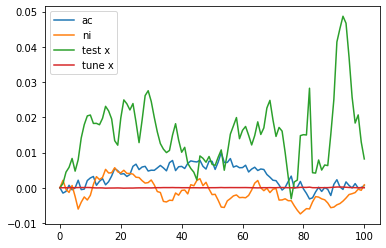

In [ ]:
ch = 5
n = 279
print(tsy[n])
plt.plot(th_ac[ch], label = "ac")
plt.plot(th_ni[ch], label = "ni")
plt.plot(tsX[n, ch, :], label = "test x")
plt.plot(tune_tsX[n, ch, :], label = "tune x")
plt.legend()
plt.show()

In [ ]:
tAc, _ = raw_to_data(active[0], 2) #active
tNi, _ = raw_to_data(active[0], 1) #ignore

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.8s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

(540, 101)
[[0.42767676 0.42663765 0.41990823 ... 0.27955363 0.28217901 0.2851024 ]
 [0.51975023 0.52100984 0.51809801 ... 0.40177789 0.41414644 0.42113105]
 [0.64611488 0.65635824 0.66183444 ... 0.48707139 0.49668694 0.49962107]
 ...
 [0.43924354 0.44471764 0.44264174 ... 0.43964737 0.4403302  0.44237442]
 [0.27919097 0.2831596  0.28221681 ... 0.36268622 0.36608652 0.36811399]
 [0.39889199 0.40653159 0.41107821 ... 0.45664198 0.46309655 0.46508958]] [[-0.42767676 -0.42663765 -0.41990823 ... -0.27955363 -0.28217901
  -0.2851024 ]
 [-0.51975023 -0.52100984 -0.51809801 ... -0.40177789 -0.41414644
  -0.42113105]
 [-0.64611488 -0.65635824 -0.66183444 ... -0.48707139 -0.49668694
  -0.49962107]
 ...
 [-0.43924354 -0.44471764 -0.44264174 ... -0.43964737 -0.4403302
  -0.44237442]
 [-0.27919097 -0.2831596  -0.28221681 ... -0.36268622 -0.36608652
  -0.36811399]
 [-0.39889199 -0.40653159 -0.41107821 ... -0.45664198 -0.46309655
  -0.46508958]]


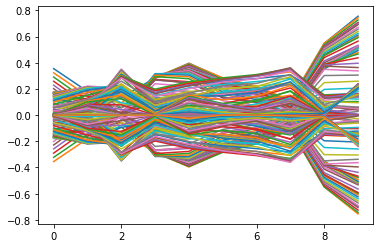

In [ ]:
print(tX[:, 1, :].shape)
tAc.reshape(10,-1, 101).shape
tmp = th_ac.copy()
print(tmp, tmp*(-1))

plt.plot(tX[0])
plt.plot(tX[0]*(-1))
plt.show()

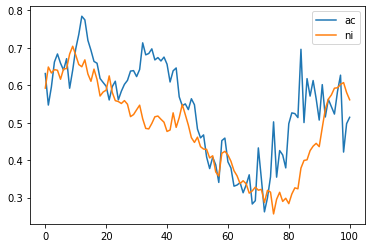

In [ ]:
tAc = tAc.reshape(10,-1, 101)
tNi = tNi.reshape(10,-1, 101)
th_ac = np.zeros([10, 101])
th_ni = np.zeros([10, 101])

for ch in range(10):
  th_ac[ch] = np.mean(tAc[ch], axis = 0)
  th_ni[ch] = np.mean(tNi[ch], axis = 0)



plt.plot(th_ac[0], label = "ac")
plt.plot(th_ni[0], label = "ni")
plt.legend()
plt.show()



In [ ]:
th_ac.shape

(10, 101)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

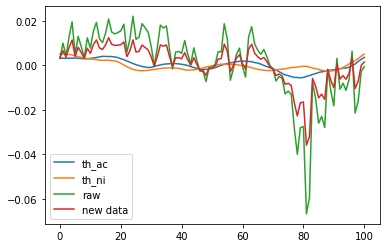

In [ ]:
k = 3
m = 123
data_ac = th_ac.copy()
data_ni = th_ni.copy()

# data_ac = np.squeeze(tmp_ac[k,:]) # Shape is now: (10, 80)

# data_ni = np.squeeze(tmp_ni[k, :]) # Shape is now: (10, 80)

# data_raw = np.squeeze(tX[m, k, :]) # Shape is now: (10, 80)
print(ty[m])

data_ac[k] = savitzky_golay(data_ac[k], window_size=29, order=4)
data_ni[k] = savitzky_golay(data_ni[k], window_size=29, order=4)

if ty[m] == 1: 
  after_tune = (tX[m] + data_ac)/2
else: 
  after_tune = (tX[m] + data_ni)/2



plt.plot(data_ac[k], label="th_ac")
plt.plot(data_ni[k], label="th_ni")
plt.plot(tX[m, k, :], label="raw")
plt.plot(after_tune[k, :], label="new data") # plotting by columns
plt.legend()
plt.show()

In [ ]:
ac, _ = raw_to_data(active[0], 0)
pas, _ = raw_to_data(passive[0], 1)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.6s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

(101,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

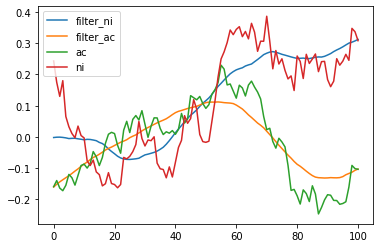

In [ ]:
plt_ac = np.mean(ac[:,4,:], axis =0)*100
plt_ni = np.mean(pas[:,1,:], axis =0)*100

z = plt_ac
print(z.shape)

plt_ac_sg = savitzky_golay(z, window_size=35, order=0)
plt_ni_sg = savitzky_golay(plt_ni, window_size=35, order=0)

plt.plot(plt_ni_sg, label = "filter_ni")
plt.plot(plt_ac_sg, label = "filter_ac")
plt.plot(plt_ac, label = "ac")
plt.plot(plt_ni, label = "ni")
plt.legend()
plt.show()

In [ ]:
plt_ac.shape

(101,)

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(8, kernel_size=(4, 40),activation='relu',input_shape=(10,101,1),padding='same'))
# cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(16, (4, 80), activation='relu',padding='same'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (4, 80), activation='relu',padding='same'))         
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid'))

cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 10, 101, 8)        1288      
                                                                 
 batch_normalization_46 (Bat  (None, 10, 101, 8)       32        
 chNormalization)                                                
                                                                 
 dropout_54 (Dropout)        (None, 10, 101, 8)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 10, 101, 16)       40976     
                                                                 
 batch_normalization_47 (Bat  (None, 10, 101, 16)      64        
 chNormalization)                                                
                                                                 
 dropout_55 (Dropout)        (None, 10, 101, 16)     

In [ ]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')        

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# DeepEEG

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


In [ ]:
model = ShallowConvNet(nb_classes = 2, Chans = 10, Samples = 101)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
# train_y = np_utils.to_categorical(train_y-1)
test_y = np_utils.to_categorical(test_y-1)

train_X = train_X.reshape(-1, 10,101, 1)
test_X = test_X.reshape(-1, 10,101, 1)

train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                            train_y, 
                                                            test_size=0.2, 
                                                            random_state=13)

train_label_categorical = np_utils.to_categorical(train_label-1)
valid_label_categorical = np_utils.to_categorical(valid_label-1)

fittedModel = model.fit(train_X, train_label_categorical, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(valid_X, valid_label_categorical))


Epoch 1/300
27/27 - 1s - loss: 0.6430 - val_loss: 0.6093 - 1s/epoch - 43ms/step
Epoch 2/300
27/27 - 0s - loss: 0.4800 - val_loss: 0.6354 - 424ms/epoch - 16ms/step
Epoch 3/300
27/27 - 0s - loss: 0.4429 - val_loss: 0.6564 - 390ms/epoch - 14ms/step
Epoch 4/300
27/27 - 0s - loss: 0.4021 - val_loss: 0.6706 - 412ms/epoch - 15ms/step
Epoch 5/300
27/27 - 0s - loss: 0.3870 - val_loss: 0.5725 - 395ms/epoch - 15ms/step
Epoch 6/300
27/27 - 0s - loss: 0.3639 - val_loss: 0.6241 - 402ms/epoch - 15ms/step
Epoch 7/300
27/27 - 0s - loss: 0.3266 - val_loss: 0.6733 - 402ms/epoch - 15ms/step
Epoch 8/300
27/27 - 0s - loss: 0.3624 - val_loss: 0.6306 - 403ms/epoch - 15ms/step
Epoch 9/300
27/27 - 0s - loss: 0.3226 - val_loss: 0.7084 - 407ms/epoch - 15ms/step
Epoch 10/300
27/27 - 0s - loss: 0.3270 - val_loss: 0.9332 - 395ms/epoch - 15ms/step
Epoch 11/300
27/27 - 0s - loss: 0.2918 - val_loss: 0.6019 - 402ms/epoch - 15ms/step
Epoch 12/300
27/27 - 0s - loss: 0.2884 - val_loss: 0.9955 - 406ms/epoch - 15ms/step
Epoc

In [ ]:
probs       = model.predict(test_X)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == test_y.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.460714 
